In [118]:
# %load main.py
import networkx as nx
import random as rand
from utils import *
import math

class Person(object):
    #static variable
    population = 0
    def __init__(self,id_num=None,ideo=None, capacity=4.0):
        self.id_num = id_num if id_num!=None else Person.population
        Person.population += 1
        self.ideo = ideo if ideo!=None else rand.uniform(-1,1)
        #2*randint(0,1)-1
        #rand.uniform(-1,1)
        self.capacity = capacity
    def __eq__(self,other):
        if not (isinstance(other,Person)):
            return False
        return self.id_num==other.id_num
    def __hash__(self):
        return hash(self.id_num)

def clamp(x,lo=0,hi=1):
    return lo if x<lo else \
           hi if x>hi else x

def new_ideo(graph,node,wt=0.9,noise=0.05):
    s = sum_friend_weights(graph,node)
    return clamp(wt*node.ideo 
        + ((1-wt)*sum([nbr.ideo*graph.adj[node][nbr]['weight'] for nbr in graph.adj[node]])/s
                 if s!=0 else (1-wt)*node.ideo)
        + rand.gauss(0,noise),-1,1)

def update_ideos(graph, wt=0.9,noise=0.05):
    ideos = [new_ideo(graph,node,wt,noise) for node in graph.nodes()]
    for (node, ideo) in zip(graph.nodes(),ideos):
        node.ideo = ideo
        
def update_friendships(graph, node, sigma=0.05):
    dels = []
    for nbr in graph.adj[node]:
        graph.adj[node][nbr]['weight']= clamp(graph.adj[node][nbr]['weight'] + rand.gauss(0,sigma))
        if graph.adj[node][nbr]['weight']==0:
            dels +=[nbr]
    for nbr in dels:
        graph.remove_edge(node,nbr)

def get_potential_friend(graph, node, p=0.1):
    if rand.random()<p:
        friend = sample(list(graph.nodes()))
    else:
        f = step_rand_walk(graph,node)
        if f==None:
            return None
        friend = step_rand_walk(graph,f)
        if friend==None:
            return None #this shouldn't happen
    if not (friend == None or node == friend or friend in graph.adj[node]):
        #graph.add_edge(node, friend, weight=0.5)
        return friend
    return None

def maybe_make_friend(graph, node, p=0.1, acc_fn=lambda me, you: math.exp(-abs(me.ideo-you.ideo))):
    if rand.random()<=(node.capacity - sum_friend_weights(graph,node))/node.capacity:
        friend = get_potential_friend(graph,node,p)
        if friend == None:
            return None
        if rand.random()<=acc_fn(node, friend):
            graph.add_edge(node, friend, weight=0.5)
            return friend
    return None

def sum_friend_weights(graph,node):
    return sum([graph.adj[node][neighbor]['weight'] for neighbor in graph.adj[node]])

def step_rand_walk(graph, node):
    #print(node)
    sum_weights = sum_friend_weights(graph, node)
    if sum_weights==0:
        return None
    li = [(neighbor, graph.adj[node][neighbor]['weight']/sum_weights) for neighbor in graph.adj[node]]
    #print(li)
    x = sample_wp(li)
    #print("hi",x)
    return x

def sample(li):
    if len(li)==0:
        return None
    return li[rand.randint(0,len(li)-1)]

def loop_step(graph,sigma=0.1,p=0.1,
              acc_fn=lambda me, you: math.exp(-abs(me.ideo-you.ideo)),
              wt=0.9,noise=0.05):
    for node in graph.nodes():
        update_ideos(graph, wt, noise)
        update_friendships(graph,node,sigma)
        maybe_make_friend(graph,node,p,acc_fn)

def init_graph(pop):
    nodes = [Person() for i in range(pop)]
    G=nx.Graph()
    G.add_nodes_from(nodes)
    return G

def test():
    G = nx.Graph()
    G.add_nodes_from([1,2,3,4,5,6])
    G.add_edges_from([(1,2,{'weight':1.0}),
                      (1,3,{'weight':2.0}),
                      (2,4,{'weight':10.0}),
                      (3,5,{'weight':10.0}),
                      (3,6,{'weight':20.0})])
    #print(G.adj)
    for t in range(15):
        print(step_rand_walk(G,step_rand_walk(G,1)))
    nx.draw(G)
    p=Person()
    q=Person()
    print(Person.population)
    
#if __name__=='__main__':
#    #test()
#    G=init_graph(10)
#    for t in range(100):
#        loop_step(G)
#        if t%10==0:
#            nx.draw(G)


In [119]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.clf()

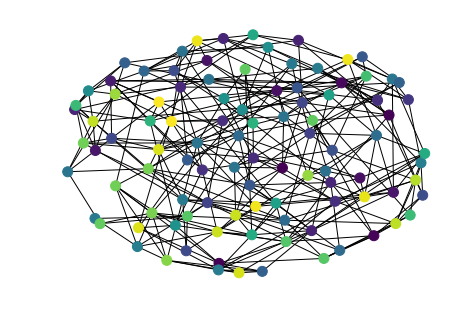

In [120]:
G=init_graph(100)
colors = [person.ideo for person in G.nodes()]
#print(G.nodes())
for t in range(1000):
    loop_step(G, sigma=0.1,p=0.1, acc_fn=lambda me, you: math.exp(-abs(me.ideo-you.ideo)))
plt.clf()
nx.draw(G, node_size=100, node_color = colors, cmap=plt.cm.viridis)
#nx.draw(G)

In [27]:
import numpy.linalg as la
import numpy as np
L=nx.linalg.laplacian_matrix(G).toarray()
#print(L,type(L))
la.eig(L)[1]

array([[-0.03954396, -0.03698582,  0.1       , ..., -0.01150548,
        -0.00451752, -0.02222323],
       [-0.03416462,  0.03301456,  0.1       , ...,  0.11229867,
        -0.01980096,  0.05342239],
       [-0.01018709,  0.03171079,  0.1       , ...,  0.16775703,
        -0.03890454, -0.016685  ],
       ..., 
       [ 0.0021946 , -0.00482569,  0.1       , ..., -0.02831872,
        -0.02311948,  0.01071911],
       [-0.00786924, -0.00458879,  0.1       , ...,  0.02938302,
         0.02372548, -0.03132436],
       [ 0.003561  , -0.00571767,  0.1       , ..., -0.10080388,
        -0.00045162, -0.15642039]])

In [98]:

def draw_graph(graph):
    data = []
    L=nx.linalg.laplacian_matrix(G).toarray()
    v1 = la.eig(L)[1][1]
    v2 = la.eig(L)[1][2]
    d = {}
    for n in graph.nodes():
        d[n] = [v1[n.id_num],v2[n.id_num]]
    #for (p1,p2) in graph.edges():
    #    plt.plot((v1[p1.id_num], v1[p2.id_num]),(v2[p1.id_num], v2[p2.id_num]))
    #    #data += [(v1[p1.id_num], v2[p1.id_num]), (v1[p1.id_num], v2[p1.id_num]),'b']
    #plt.scatter(v1,v2)
    nx.draw(G, node_size=50, node_color = colors, cmap=plt.cm.viridis, pos=d)
    

In [105]:
draw_graph(G)

IndexError: index 100 is out of bounds for axis 0 with size 100

In [31]:
G = nx.Graph()
G.add_nodes_from([1,2,3,4,5,6])
G.nodes()

[1, 2, 3, 4, 5, 6]

In [32]:
G.edges()

[]

In [16]:
rand.randint(0,2)

0

In [6]:
import math
math.exp(4)

54.598150033144236